In [ ]:
!pip install swifter

In [1]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure, plot
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import swifter

pd.set_option('display.max_columns', 200)


In [93]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [512]:
def plot_feature_importance(importance, names, message=""):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[:20]
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title('FEATURE IMPORTANCE' + " " + message)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [366]:
from geopy.distance import geodesic as GD 

def calc_distance(lat, lon):
    SVO_airport = (55.972641, 37.414581)
    dest_airport = (lat, lon) 
    return GD(SVO_airport, dest_airport).km

In [21]:
airports = requests.get("https://www.flightradar24.com/_json/airports.php", headers= {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36 OPR/51.0.2830.55"
    }).json()["rows"]
airports = pd.DataFrame(airports)


In [634]:
revenue_05 = pd.read_excel("/Users/igor/Downloads/Шереметьево  2/05.2022_Выручка.xlsx")
revenue_06 = pd.read_excel("/Users/igor/Downloads/Шереметьево  2/06.2022_Выручка.xlsx")

revenue_05 = revenue_05.rename(columns={"Дата": "date", 
                           "Дата с разбивкой по 30 минут": "timeThirty",
                           "Прибыль на момент времени": "revenue",
                           "Точка продаж": "point",
                          })
revenue_06 = revenue_06.rename(columns={"Дата": "date", 
                           "Дата с разбивкой по 30 минут": "timeThirty",
                           "Прибыль на момент времени": "revenue",
                           "Точка продаж": "point",
                          })

revenue_05['revenue'] = revenue_05['revenue'].apply(lambda x: str(x).replace(u'\xa0', u''))
revenue_05['revenue'] = revenue_05['revenue'].apply(lambda x: str(x).replace(u',', u'.'))
revenue_05["revenue"] = revenue_05["revenue"].astype(float)

revenue_06['revenue'] = revenue_06['revenue'].apply(lambda x: str(x).replace(u'\xa0', u''))
revenue_06['revenue'] = revenue_06['revenue'].apply(lambda x: str(x).replace(u',', u'.'))
revenue_06["revenue"] = revenue_06["revenue"].astype(float)

revenue_05 = revenue_05.drop(columns="date")
revenue_06 = revenue_06.drop(columns="date")

revenue_05 = pd.read_excel("/Users/igor/Downloads/Шереметьево  2/05.2022_Выручка.xlsx")
revenue_05 = revenue_05.rename(columns={"Дата": "date", 
                           "Дата с разбивкой по 30 минут": "timeThirty",
                           "Прибыль на момент времени": "revenue",
                           "Точка продаж": "point",
                          })
revenue_05['revenue'] = revenue_05['revenue'].apply(lambda x: str(x).replace(u'\xa0', u''))
revenue_05['revenue'] = revenue_05['revenue'].apply(lambda x: str(x).replace(u',', u'.'))
revenue_05["revenue"] = revenue_05["revenue"].astype(float)
revenue_05 = revenue_05.drop(columns="date")

In [635]:
mean_revenue = revenue_05[["point", "revenue"]].groupby(["point"]).mean().sort_values(by="revenue").reset_index().rename(columns={"revenue": "mean_revenue"})

In [636]:
revenue_05["timeThirty"] = pd.to_datetime(revenue_05.timeThirty, utc = True)
revenue_05["day_of_week"] = revenue_05["timeThirty"].dt.dayofweek
revenue_05["day_of_year"] = revenue_05["timeThirty"].dt.dayofyear
revenue_05["day"] = revenue_05["timeThirty"].dt.day
revenue_05["month"] = revenue_05["timeThirty"].dt.month
revenue_05["hour"] = revenue_05["timeThirty"].dt.hour
revenue_05["minutes"] = revenue_05["timeThirty"].dt.minute
revenue_05 = revenue_05.merge(mean_revenue, how='left', left_on='point', right_on='point')

revenue_05["is_weekend"] = np.logical_or(False, revenue_05["day_of_week"] == 6)
revenue_05["is_weekend"] = np.logical_or(revenue_05["is_weekend"], revenue_05["day_of_week"] == 7)
revenue_05["is_weekend"] = np.logical_or(revenue_05["is_weekend"], revenue_05["day"] == 2)
revenue_05["is_weekend"] = np.logical_or(revenue_05["is_weekend"], revenue_05["day"] == 3)
revenue_05["is_weekend"] = np.logical_or(revenue_05["is_weekend"], revenue_05["day"] == 9)
revenue_05["is_weekend"] = np.logical_or(revenue_05["is_weekend"], revenue_05["day"] == 10)
revenue_05["is_weekend"] = revenue_05["is_weekend"].astype(int)

In [561]:
aircraft_seats = pd.read_csv("aircraft_seats.csv")

In [571]:
dep = pd.read_csv("svo_dep_aeroflot_rossiya_05_06_2022.csv")
arr = pd.read_csv("svo_arr_aeroflot_rossiya_05_06_2022.csv")
weather = pd.read_csv("svo_weather.csv")

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [572]:
weather["datetime"] = pd.to_datetime(weather["datetime"], utc=True)
weather = weather.merge(airports[["icao", "iata"]], how='left')
weather[["iata", "datetime", "temp", "wind_speed", "visibility", "sky_coverage"]]

,iata,datetime,temp,wind_speed,visibility,sky_coverage
0,ABA,2022-04-29 00:00:00+00:00,6.0,10.8,10000.0,-1.0
1,ABA,2022-04-29 02:00:00+00:00,11.0,7.2,10000.0,-1.0
2,ABA,2022-04-29 03:00:00+00:00,14.0,7.2,10000.0,-1.0
3,ABA,2022-04-29 04:00:00+00:00,17.0,10.8,10000.0,-1.0
4,ABA,2022-04-29 05:00:00+00:00,21.0,10.8,10000.0,-1.0
...,...,...,...,...,...,...
111686,YKS,2022-07-01 19:00:00+00:00,14.0,7.2,10000.0,-1.0
111687,YKS,2022-07-01 20:00:00+00:00,16.0,3.6,10000.0,-1.0
111688,YKS,2022-07-01 21:00:00+00:00,19.0,3.6,10000.0,-1.0
111689,YKS,2022-07-01 22:00:00+00:00,22.0,3.6,10000.0,-1.0


In [573]:
dep = dep.merge(aircraft_seats, on="aircraft_type", how='left')
dep["boarding_end"] = pd.to_datetime(dep["boarding_end"])
dep["boarding_end_msk"] = dep["boarding_end"] + pd.Timedelta(hours=3)
dep["boarding_end_msk_round"] = dep['boarding_end_msk'].dt.floor('30min')
dep["boarding_end_round_1_hour"] = dep['boarding_end'].dt.floor('60min')
dep["shoping_start_msk"] = dep["boarding_end_msk"] - pd.Timedelta(hours=2)
dep["shoping_stop_msk"] = dep["boarding_end_msk"] - pd.Timedelta(minutes=30)

In [574]:
dep = dep.merge(airports, left_on='arrival_latest_airportCode', right_on='iata', how='left')

In [575]:
dep = dep.merge(weather[["iata", "datetime", "temp", "wind_speed", "visibility", "sky_coverage"]],
         left_on=['boarding_end_round_1_hour', 'iata'], right_on=['datetime', 'iata'], how='left')

In [576]:
dep

,carrier,flight_number,aircraft_type,aircraft_registration,registration_start,registration_end,boarding_start,boarding_end,departure_airportCode,departure_actualBlockOff,departure_scheduledDeparture,departure_actualTakeOff,departure_gate,departure_terminal,arrival_scheduled_airportCode,arrival_latest_airportCode,arrival_scheduledArrival,arrival_actualTouchDown,arrival_deboardingStart,arrival_deboardingStop,deboarding_start,deboarding_end,status,operatingBy,name_x,seats,seats_C,seats_W,seats_Y,boarding_end_msk,boarding_end_msk_round,boarding_end_round_1_hour,shoping_start_msk,shoping_stop_msk,name_y,iata,icao,lat,lon,country,alt,datetime,temp,wind_speed,visibility,sky_coverage
0,SU,1510,320,73762,2022-04-27T23:00:00Z,2022-04-28T22:15:00Z,2022-04-28T22:29:00Z,2022-04-28 22:53:00+00:00,SVO,2022-04-28T23:25:00Z,2022-04-28T18:45:00Z,2022-04-28T23:38:00Z,104.0,B,SGC,SGC,2022-04-28T22:00:00Z,2022-04-29T02:40:00Z,NaN,NaN,2022-04-29T02:45:00Z,2022-04-29T03:15:00Z,Arrived,SU,Airbus A320,140,20,0,120,2022-04-29 01:53:00+00:00,2022-04-29 01:30:00+00:00,2022-04-28 22:00:00+00:00,2022-04-28 23:53:00+00:00,2022-04-29 01:23:00+00:00,Surgut International Airport,SGC,USRR,61.343689,73.401840,Russia,200,NaT,NaN,NaN,NaN,NaN
1,SU,1646,320,VPBKP,2022-04-27T22:00:00Z,2022-04-28T21:15:00Z,2022-04-28T21:21:00Z,2022-04-28 21:41:00+00:00,SVO,2022-04-28T21:55:00Z,2022-04-28T19:45:00Z,2022-04-28T22:06:00Z,121.0,B,NJC,NJC,2022-04-28T23:15:00Z,2022-04-29T00:57:00Z,NaN,NaN,2022-04-29T01:01:00Z,2022-04-29T01:31:00Z,Arrived,SU,Airbus A320,140,20,0,120,2022-04-29 00:41:00+00:00,2022-04-29 00:30:00+00:00,2022-04-28 21:00:00+00:00,2022-04-28 22:41:00+00:00,2022-04-29 00:11:00+00:00,Nizhnevartovsk Airport,NJC,USNN,60.949268,76.483612,Russia,177,NaT,NaN,NaN,NaN,NaN
2,SU,1966,SU9,89026,2022-04-27T21:10:00Z,2022-04-28T20:25:00Z,2022-04-28T20:33:00Z,2022-04-28 20:54:00+00:00,SVO,2022-04-28T21:07:00Z,2022-04-28T21:10:00Z,2022-04-28T21:17:00Z,135.0,C,EVN,EVN,2022-04-29T01:15:00Z,2022-04-29T00:43:00Z,NaN,NaN,2022-04-29T00:47:00Z,2022-04-29T01:17:00Z,Arrived,SU,Sukhoi Superjet 100-95,87,12,0,75,2022-04-28 23:54:00+00:00,2022-04-28 23:30:00+00:00,2022-04-28 20:00:00+00:00,2022-04-28 21:54:00+00:00,2022-04-28 23:24:00+00:00,Yerevan Zvartnots International Airport,EVN,UDYZ,40.147270,44.395882,Armenia,2838,NaT,NaN,NaN,NaN,NaN
3,SU,1524,321,73725,2022-04-27T21:10:00Z,2022-04-28T20:25:00Z,2022-04-28T20:31:00Z,2022-04-28 21:02:00+00:00,SVO,2022-04-28T21:10:00Z,2022-04-28T21:10:00Z,2022-04-28T21:22:00Z,111.0,B,RGK,RGK,2022-04-29T01:35:00Z,2022-04-29T01:10:00Z,2022-04-28T19:49:00Z,NaN,2022-04-29T01:15:00Z,2022-04-29T01:45:00Z,Arrived,SU,Airbus A321,170,28,0,142,2022-04-29 00:02:00+00:00,2022-04-29 00:00:00+00:00,2022-04-28 21:00:00+00:00,2022-04-28 22:02:00+00:00,2022-04-28 23:32:00+00:00,Gorno-Altaysk Airport,RGK,UNBG,51.969166,85.836388,Russia,959,NaT,NaN,NaN,NaN,NaN
4,SU,1478,320,73732,2022-04-27T21:15:00Z,2022-04-28T20:30:00Z,2022-04-28T20:37:00Z,2022-04-28 21:00:00+00:00,SVO,2022-04-28T21:08:00Z,2022-04-28T21:15:00Z,2022-04-28T21:19:00Z,110.0,B,ABA,ABA,2022-04-29T01:50:00Z,2022-04-29T01:18:00Z,NaN,NaN,2022-04-29T01:22:00Z,2022-04-29T01:52:00Z,Arrived,SU,Airbus A320,140,20,0,120,2022-04-29 00:00:00+00:00,2022-04-29 00:00:00+00:00,2022-04-28 21:00:00+00:00,2022-04-28 22:00:00+00:00,2022-04-28 23:30:00+00:00,Abakan International Airport,ABA,UNAA,53.740002,91.385002,Russia,831,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13378,SU,1408,320,73766,2022-06-30T20:45:00Z,2022-07-01T20:00:00Z,2022-07-01T20:07:00Z,2022-07-01 20:32:00+00:00,SVO,2022-07-01T20:39:00Z,2022-07-01T20:45:00Z,2022-07-01T21:01:00Z,108.0,B,SVX,SVX,2022-07-01T23:10:00Z,2022-07-01T23:06:00Z,NaN,NaN,2022-07-01T23:11:00Z,2022-07-01T23:41:00Z,Arrived,SU,Airbus A320,140,20,0,120,2022-07-01 23:32:00+00:00,2022-07-01 23:30:00+00:00,2022-07-01 20:00:00+00:00,2022

In [577]:
dep["temp"] = dep.temp.fillna(-10)
dep["wind_speed"] = dep.wind_speed.fillna(-10)
dep["visibility"] = dep.visibility.fillna(-10)
dep["sky_coverage"] = dep.sky_coverage.fillna(-10)

In [578]:
dep["distance"] = dep.apply(lambda x: calc_distance(x['lat'], x['lon']), axis=1)

In [579]:
dep["departure_gate"] = dep["departure_gate"].fillna(dep["departure_gate"].mean())

In [580]:
dep["delay_time"] = pd.to_datetime(dep["departure_actualTakeOff"]) - pd.to_datetime(dep["departure_scheduledDeparture"])
dep["delay_time"] = dep["delay_time"].dt.total_seconds()

dep["boarding_time"] = pd.to_datetime(dep["boarding_end"]) - pd.to_datetime(dep["boarding_start"])
dep["boarding_time"] = dep["boarding_time"].dt.total_seconds()


In [581]:
def count_clients(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)
              ].shape[0]

def count_B_clients(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["departure_terminal"] == 'B')
              ].shape[0]

def count_C_clients(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["departure_terminal"] == 'C')
              ].shape[0]

def count_SU_clients(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["operatingBy"] == 'SU')
              ].shape[0]

def count_FV_clients(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["operatingBy"] == 'FV')
              ].shape[0]

def count_domestic_clients(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["country"] == 'Russia')
              ].shape[0]

def count_international_clients(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["country"] != 'Russia')
              ].shape[0]

def calc_sum_seats(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["seats"].sum()

def calc_sum_seats_c(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["seats_C"].sum()

def calc_sum_seats_w(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["seats_W"].sum()

def calc_sum_seats_y(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["seats_Y"].sum()

def calc_avg_distance(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["distance"].mean()

def calc_avg_temp(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["temp"].mean()

def calc_avg_lat(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["lat"].mean()

def calc_avg_lon(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["lon"].mean()

def calc_avg_boarding_time(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["boarding_time"].mean()

def calc_avg_delay_time(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["delay_time"].mean()

def calc_avg_departure_gate(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["departure_gate"].mean()

def calc_min_departure_gate(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["departure_gate"].min()

def calc_max_departure_gate(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["departure_gate"].max()


def calc_elev1C_departure_gate(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["departure_gate"] >= 130) & 
               (dep["departure_gate"] <= 133) 
              ].shape[0]

def calc_elev2C_departure_gate(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["departure_gate"] >= 145) & 
               (dep["departure_gate"] <= 146) 
              ].shape[0]

def calc_elev3C_departure_gate(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (
               ((dep["departure_gate"] >= 124) & (dep["departure_gate"] <= 129)) | ((dep["departure_gate"] >= 134) & (dep["departure_gate"] <= 144))
               )
              ].shape[0]

def calc_elev1B_departure_gate(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["departure_gate"] >= 101) & 
               (dep["departure_gate"] <= 104)
              ].shape[0]

def calc_elev2B_departure_gate(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["departure_gate"] >= 122) & 
               (dep["departure_gate"] <= 123)
              ].shape[0]

def calc_elev3B_departure_gate(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["departure_gate"] >= 105) & 
               (dep["departure_gate"] <= 121)
              ].shape[0]

In [582]:
s = weather[weather["iata"]=='SVO'][["datetime", "temp", "wind_speed", "visibility", "sky_coverage"]]

df = revenue_05.copy(True)
df["timeHour"] = df['timeThirty'].dt.floor('60min')
df = df.merge(s, left_on='timeHour', right_on='datetime', how='left')

In [583]:
df["count_clients"] = df['timeThirty'].swifter.apply(lambda x: count_clients(x))
df["count_B_clients"] = df['timeThirty'].swifter.apply(lambda x: count_B_clients(x))
df["count_C_clients"] = df['timeThirty'].swifter.apply(lambda x: count_C_clients(x))
df["count_SU_clients"] = df['timeThirty'].swifter.apply(lambda x: count_SU_clients(x))
df["count_FV_clients"] = df['timeThirty'].swifter.apply(lambda x: count_FV_clients(x))

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

In [584]:
df["count_domestic_clients"] = df['timeThirty'].swifter.apply(lambda x: count_domestic_clients(x))
df["count_international_clients"] = df['timeThirty'].swifter.apply(lambda x: count_international_clients(x))
df["calc_sum_seats"] = df['timeThirty'].swifter.apply(lambda x: calc_sum_seats(x))
df["calc_sum_seats_c"] = df['timeThirty'].swifter.apply(lambda x: calc_sum_seats_c(x))
df["calc_sum_seats_w"] = df['timeThirty'].swifter.apply(lambda x: calc_sum_seats_w(x))
df["calc_sum_seats_y"] = df['timeThirty'].swifter.apply(lambda x: calc_sum_seats_y(x))

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

In [588]:
df["calc_avg_distance"] = df['timeThirty'].swifter.apply(lambda x: calc_avg_distance(x))
df["calc_avg_temp"] = df['timeThirty'].swifter.apply(lambda x: calc_avg_temp(x))
df["calc_avg_lat"] = df['timeThirty'].swifter.apply(lambda x: calc_avg_lat(x))
df["calc_avg_lon"] = df['timeThirty'].swifter.apply(lambda x: calc_avg_lon(x))
df["calc_avg_boarding_time"] = df['timeThirty'].swifter.apply(lambda x: calc_avg_boarding_time(x))
df["calc_avg_delay_time"] = df['timeThirty'].swifter.apply(lambda x: calc_avg_delay_time(x))
df["calc_avg_departure_gate"] = df['timeThirty'].swifter.apply(lambda x: calc_avg_departure_gate(x))

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

In [589]:
df["calc_min_departure_gate"] = df['timeThirty'].swifter.apply(lambda x: calc_min_departure_gate(x))
df["calc_max_departure_gate"] = df['timeThirty'].swifter.apply(lambda x: calc_max_departure_gate(x))
df["calc_elev1C_departure_gate"] = df['timeThirty'].swifter.apply(lambda x: calc_elev1C_departure_gate(x))
df["calc_elev2C_departure_gate"] = df['timeThirty'].swifter.apply(lambda x: calc_elev2C_departure_gate(x))
df["calc_elev3C_departure_gate"] = df['timeThirty'].swifter.apply(lambda x: calc_elev3C_departure_gate(x))
df["calc_elev1B_departure_gate"] = df['timeThirty'].swifter.apply(lambda x: calc_elev1B_departure_gate(x))
df["calc_elev2B_departure_gate"] = df['timeThirty'].swifter.apply(lambda x: calc_elev2B_departure_gate(x))
df["calc_elev3B_departure_gate"] = df['timeThirty'].swifter.apply(lambda x: calc_elev3B_departure_gate(x))

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

In [590]:
df["int_point"] = df["point"].apply(lambda x: x.split(" ")[-1:][0])

In [591]:
df["int_point"] = df["int_point"].astype(int)

In [592]:
df2 = df[df["point"]=='Точка продаж 3']

In [593]:
df2.revenue.quantile([0, .1, .5, .9, 1]), df2.revenue.quantile([.1, .9]).iloc[1] - df2.revenue.quantile([.1, .9]).iloc[0]


(0.0       98.5
 0.1     1148.5
 0.5     4176.5
 0.9     7119.5
 1.0    11695.5
 Name: revenue, dtype: float64,
 5971.0)

In [656]:
X = df.drop(columns=['timeThirty', 'timeHour', 'revenue', 'point', 
                      # 'mean_revenue',
                     ])
X = df[['mean_revenue', 'int_point']]
y = df['revenue']

In [657]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [658]:
clf = CatBoostRegressor(random_state=42, eval_metric="RMSE", iterations=100)
clf.fit(X_train, y_train,
        # cat_features=["point"],
        eval_set=(X_test, y_test),
        plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.329756
0:	learn: 5278.1364231	test: 5257.8881134	best: 5257.8881134 (0)	total: 8.43ms	remaining: 834ms
1:	learn: 4964.1342721	test: 4959.5539620	best: 4959.5539620 (1)	total: 11.7ms	remaining: 574ms
2:	learn: 4804.5756821	test: 4811.3361023	best: 4811.3361023 (2)	total: 14.3ms	remaining: 464ms
3:	learn: 4726.4402170	test: 4742.6825627	best: 4742.6825627 (3)	total: 16.3ms	remaining: 391ms
4:	learn: 4692.3403099	test: 4713.6881572	best: 4713.6881572 (4)	total: 18.4ms	remaining: 350ms
5:	learn: 4673.6757403	test: 4699.4784402	best: 4699.4784402 (5)	total: 20.3ms	remaining: 319ms
6:	learn: 4664.9094325	test: 4694.4036869	best: 4694.4036869 (6)	total: 22.1ms	remaining: 294ms
7:	learn: 4660.9457926	test: 4692.4564638	best: 4692.4564638 (7)	total: 24.4ms	remaining: 280ms
8:	learn: 4658.9447829	test: 4691.8761713	best: 4691.8761713 (8)	total: 25.8ms	remaining: 261ms
9:	learn: 4658.1563098	test: 4691.3166459	best: 4691.3166459 (9)	total: 28.3ms	remaining: 255ms
10:	learn:

In [659]:
y_predicted = clf.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
mae = mean_absolute_error(y_test, y_predicted)
rmse, mae

(4691.02738480352, 2711.7499991002824)

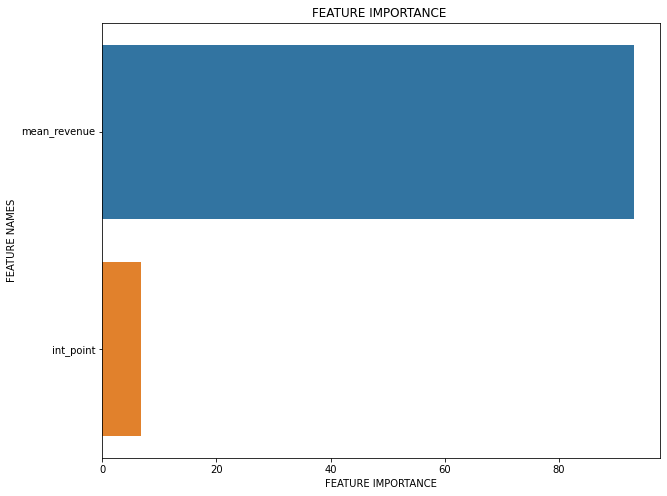

In [660]:
plot_feature_importance(clf.get_feature_importance(),
                        X.columns)

Acc  Точка продаж 23 = 71.4902849435601 %
Acc  Точка продаж 12 = 80.65836583282065 %
Acc  Точка продаж 3 = 81.21030165766678 %
Acc  Точка продаж 28 = 78.86217589855036 %
Acc  Точка продаж 22 = 74.30255324605257 %
Acc  Точка продаж 13 = 67.71908460106991 %
Acc  Точка продаж 8 = 79.87938656491866 %
Acc  Точка продаж 16 = 78.37873005150296 %
Acc  Точка продаж 1 = 64.51246424728984 %
Acc  Точка продаж 7 = 70.62342459972662 %
Acc  Точка продаж 10 = 81.93209673199743 %
Acc  Точка продаж 19 = 80.55174396566939 %
Acc  Точка продаж 24 = 72.25807763278006 %
Acc  Точка продаж 2 = 73.4044674786623 %
Acc  Точка продаж 4 = 74.37578107691287 %
Acc  Точка продаж 9 = 79.15522635758181 %
Acc  Точка продаж 5 = 84.812164091836 %
Acc  Точка продаж 25 = 72.85104460134613 %
Acc  Точка продаж 27 = 69.17589155416773 %
Acc  Точка продаж 11 = 60.31381032088845 %
Acc  Точка продаж 20 = 57.77052926141422 %
Acc  Точка продаж 18 = 68.43181525698898 %


/var/folders/gj/xhzsd7h13fj01p074fh66b0w0000gn/T/ipykernel_52775/2291967338.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,8))


Acc  Точка продаж 14 = 65.12723824225372 %
Acc  Точка продаж 29 = 85.59185428607483 %
Acc  Точка продаж 21 = 72.29562437264626 %
Acc  Точка продаж 6 = 63.844261542677 %
Acc  Точка продаж 26 = 61.15762839049774 %
Acc  Точка продаж 15 = 69.64719496439213 %
Acc  Точка продаж 17 = 68.61246079589357 %


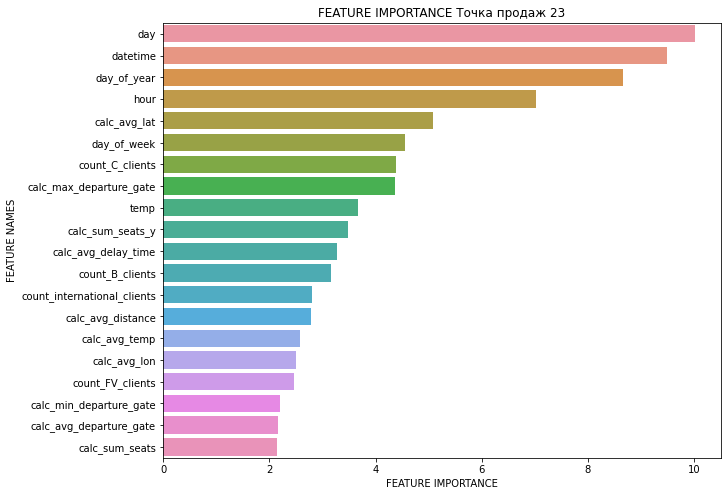

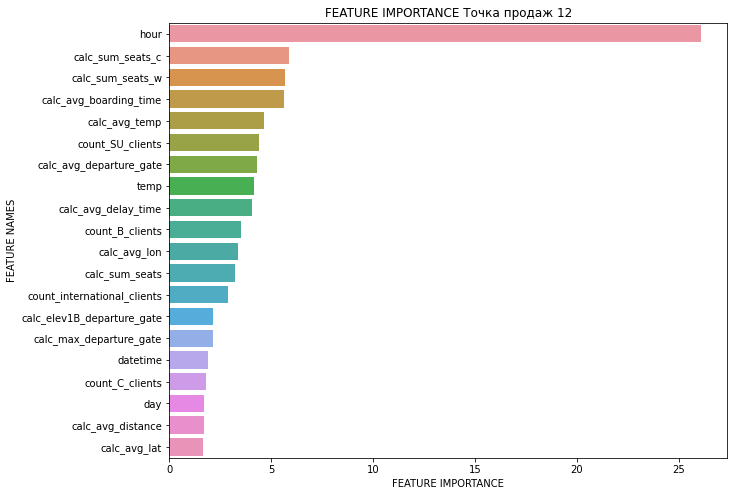

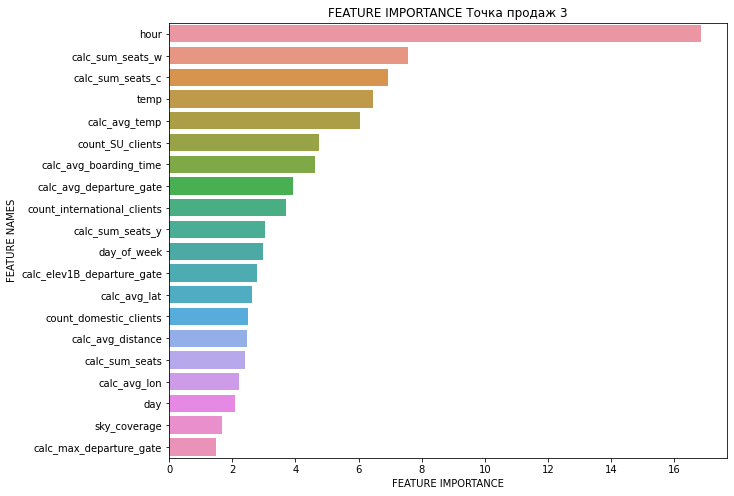

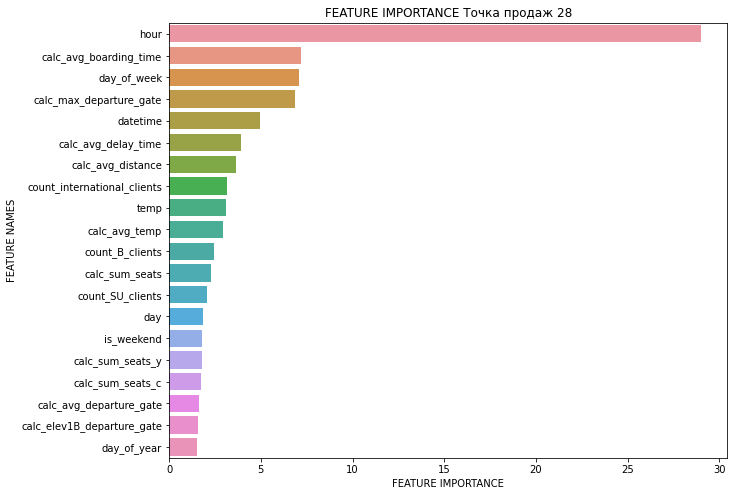

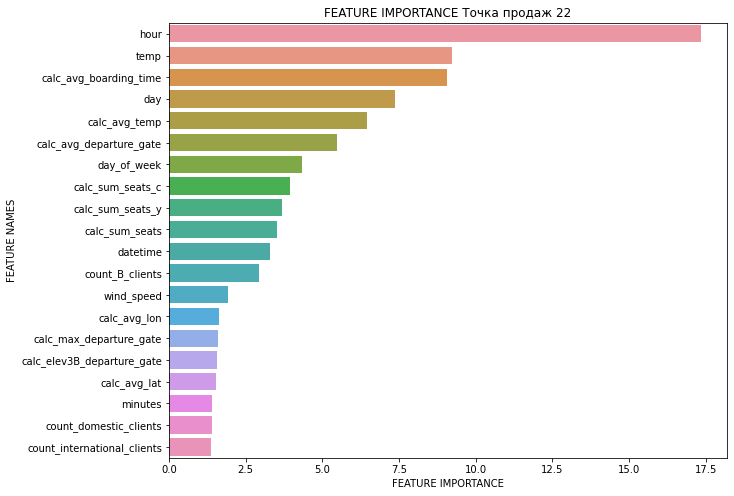

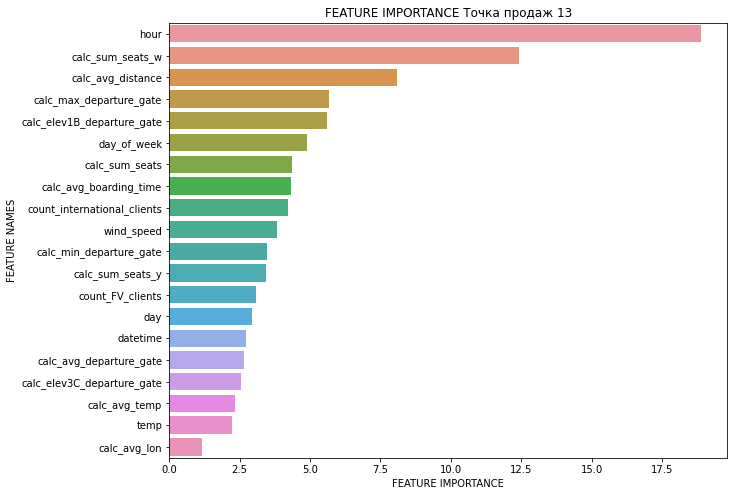

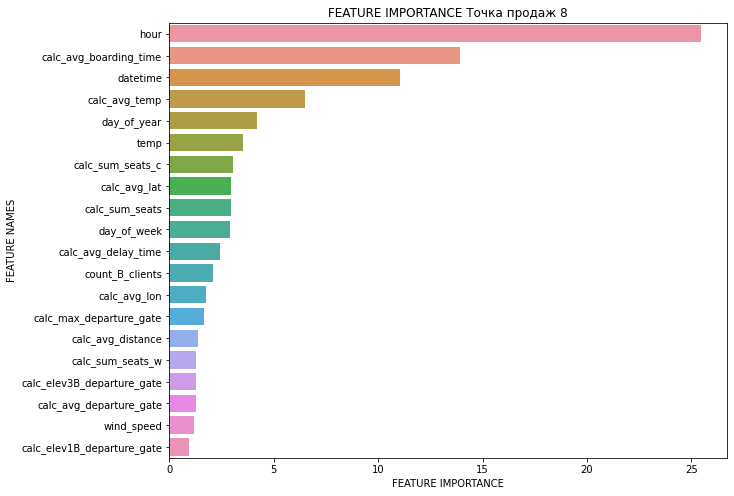

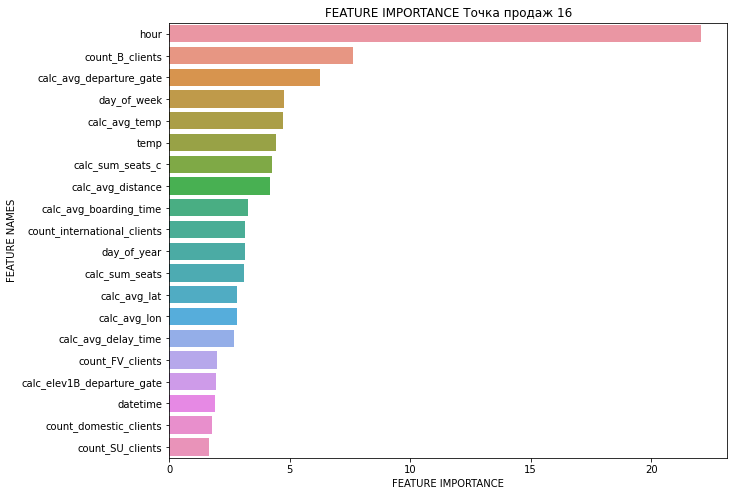

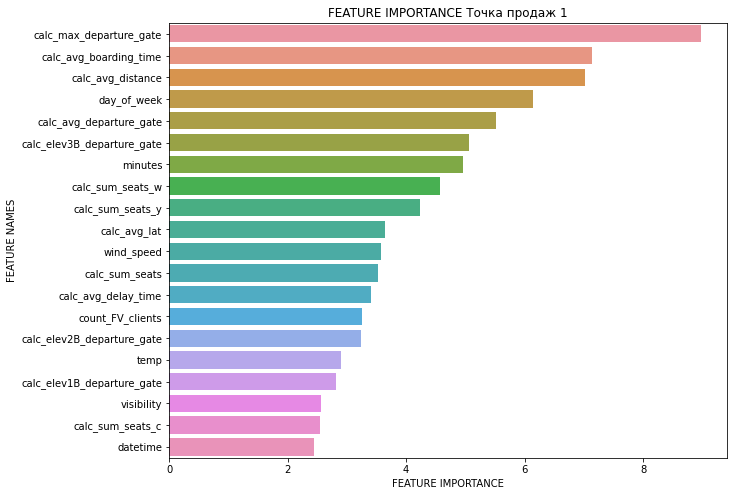

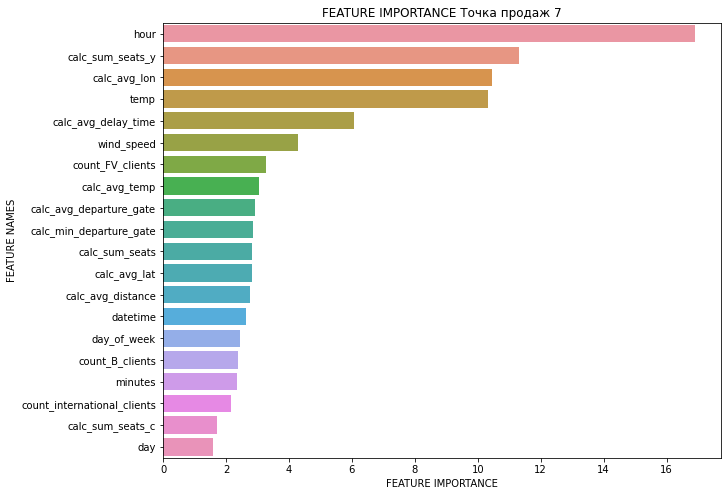

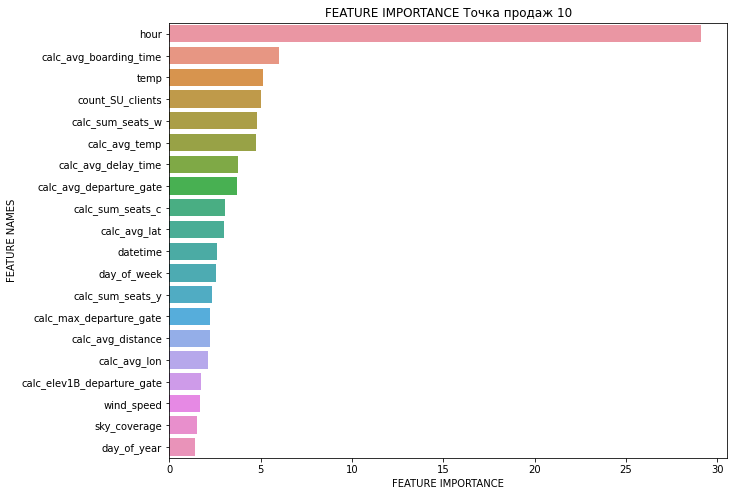

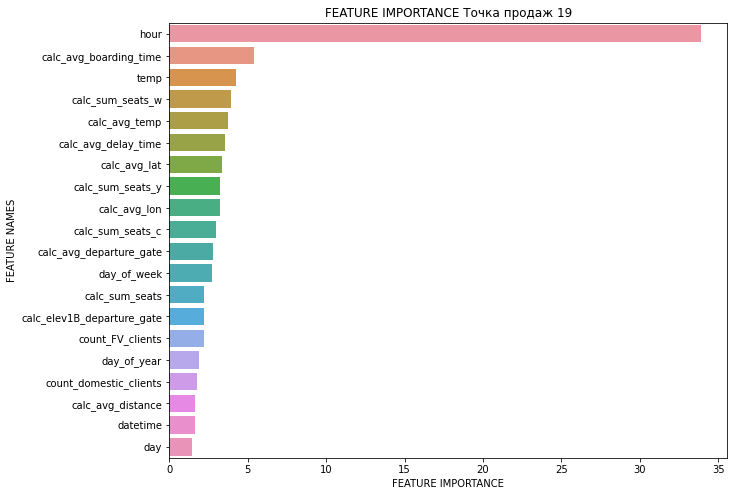

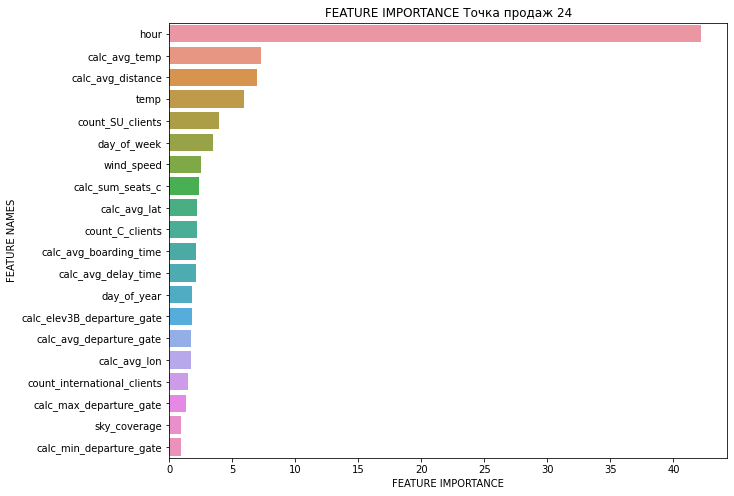

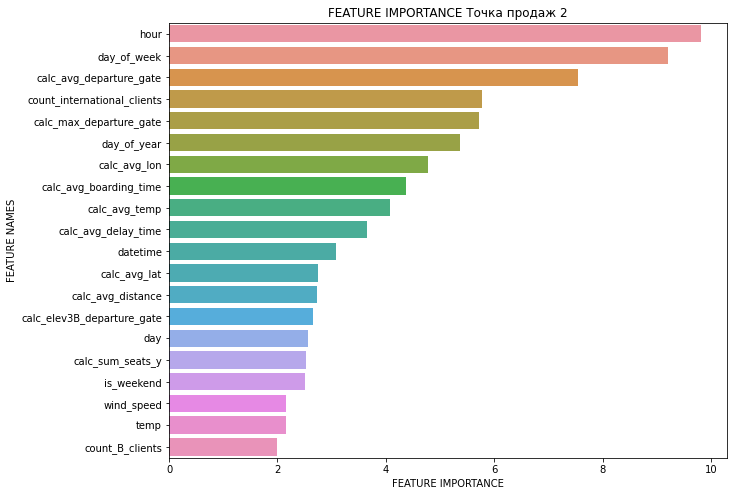

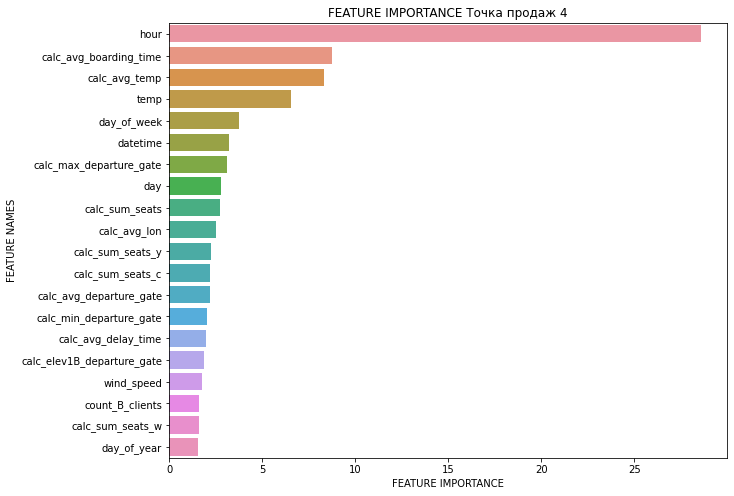

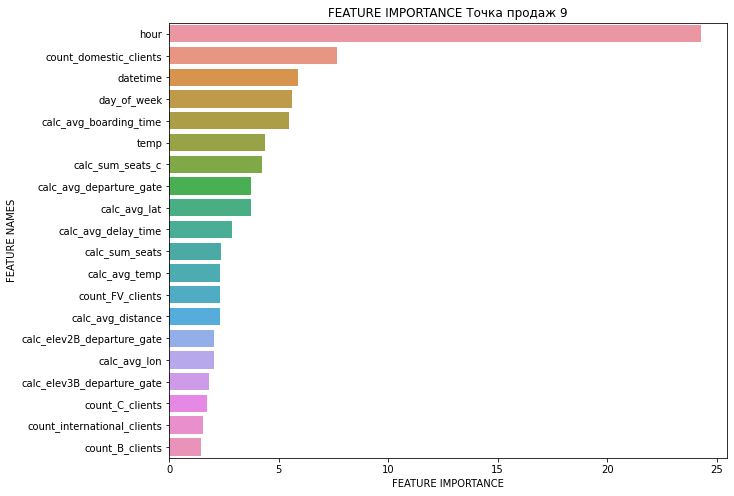

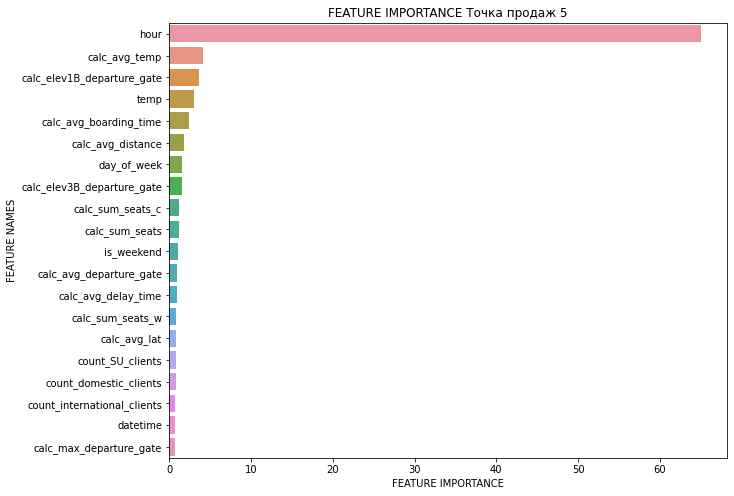

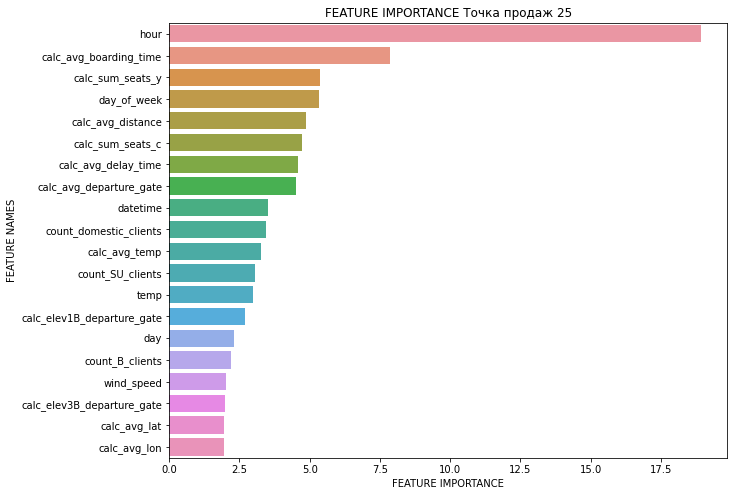

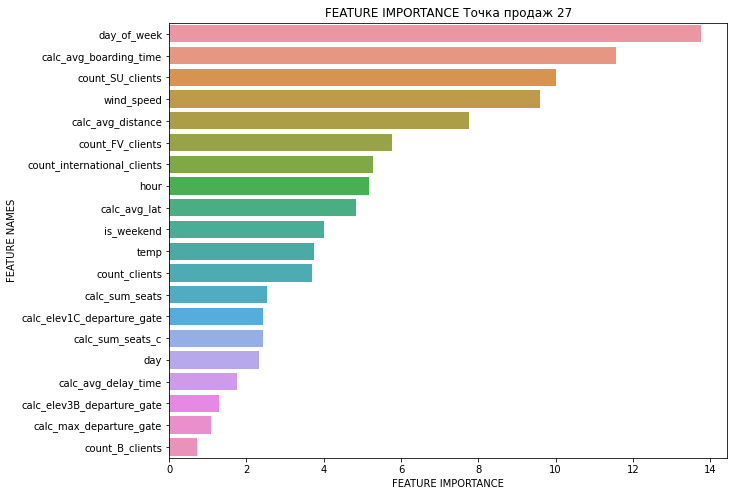

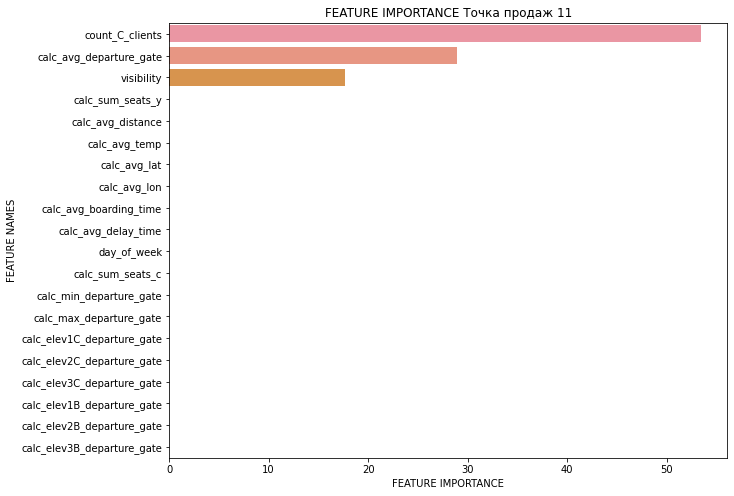

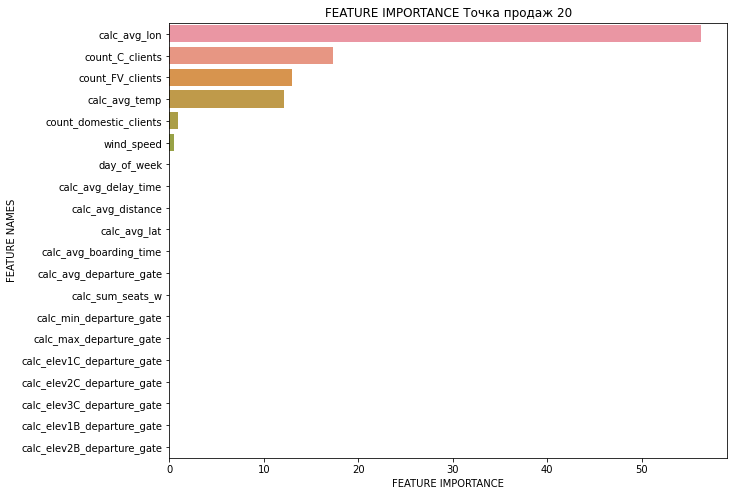

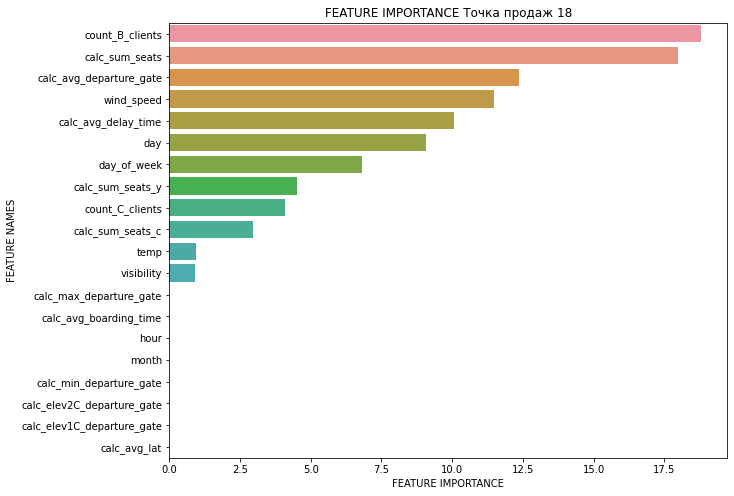

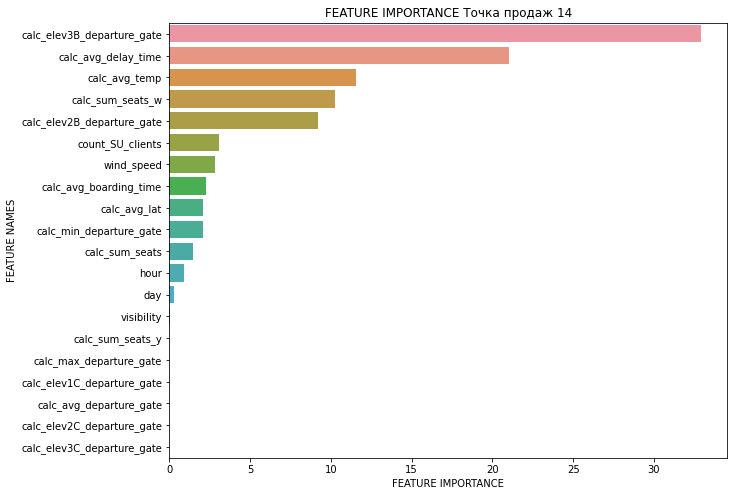

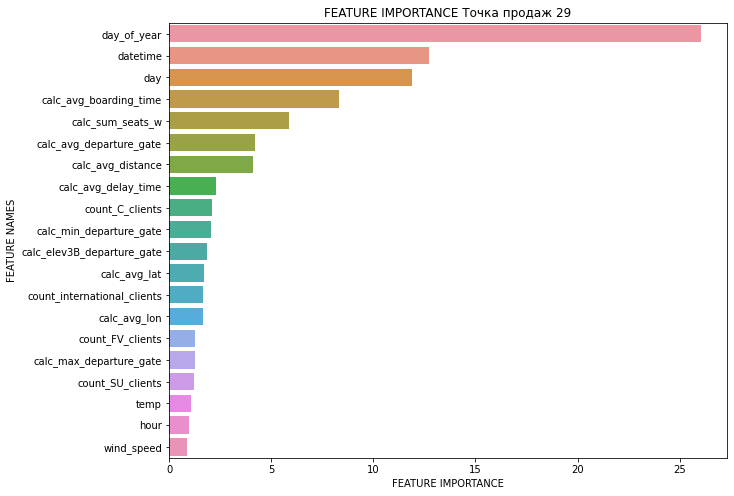

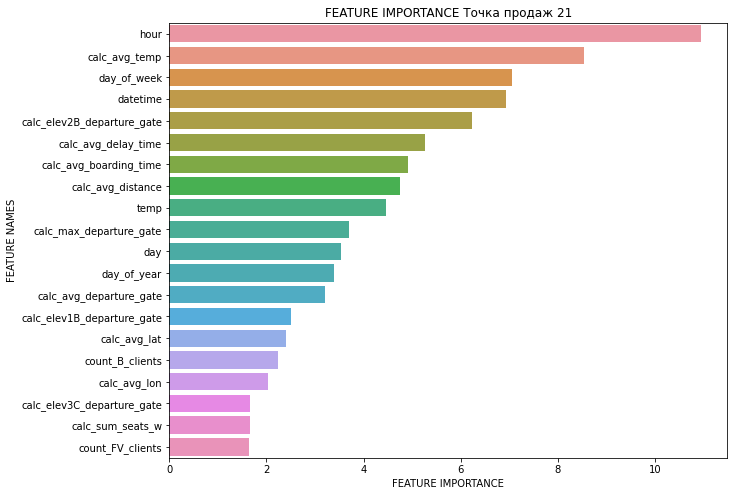

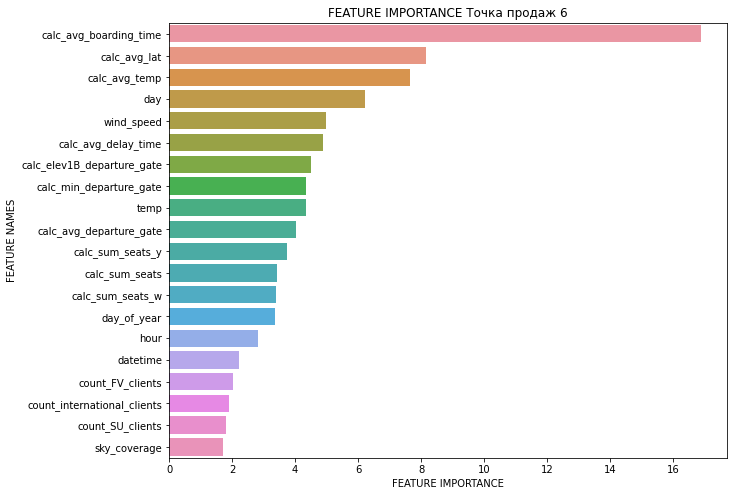

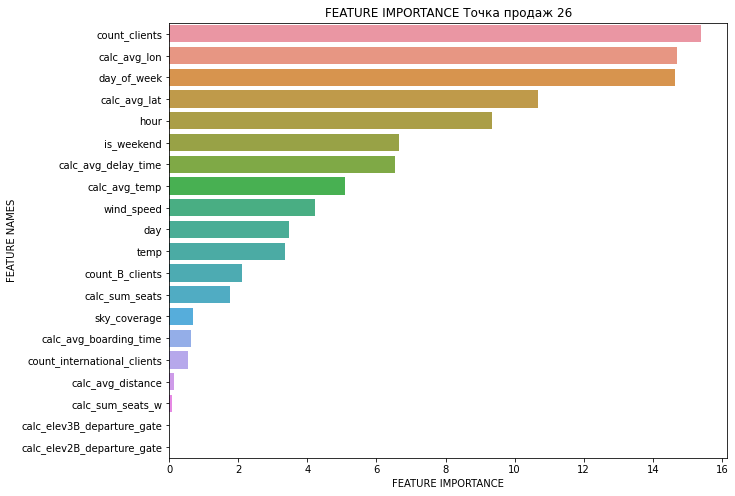

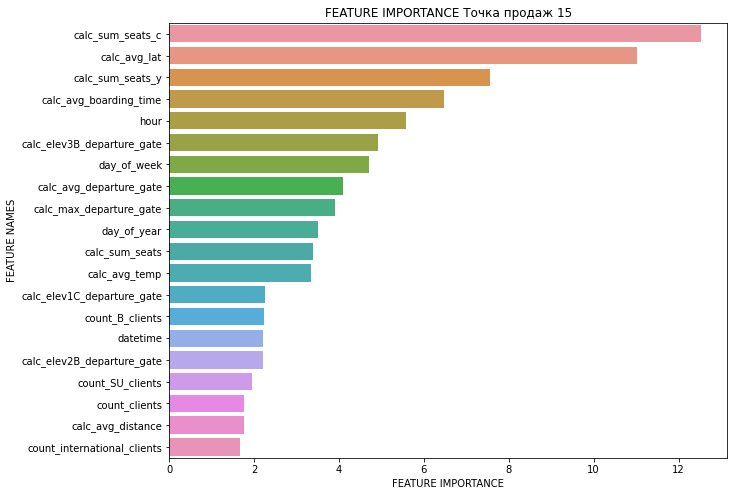

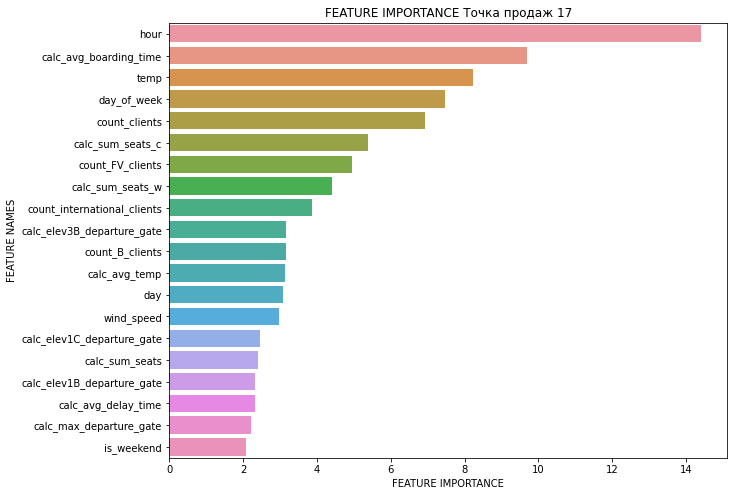

In [599]:
for i in df.point.unique():
    df2 = df[df["point"]==i]
    razmakh = df2.revenue.quantile([.1, .9]).iloc[1] - df2.revenue.quantile([.1, .9]).iloc[0]
    X = df2.drop(columns=['timeThirty', 'timeHour', 'revenue', 'point', 
                      # 'mean_revenue'
                     ])
    y = df2['revenue']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = CatBoostRegressor(random_state=42, eval_metric="RMSE", iterations=100)
    clf.fit(X_train, y_train,
        # cat_features=["point"],
        eval_set=(X_test, y_test),
        plot=False, verbose=False
    )
    y_predicted = clf.predict(X_test)
    rmse = mean_squared_error(y_test, y_predicted, squared=False)
    mae = mean_absolute_error(y_test, y_predicted)
    print("Acc ", i, "=", (1 - mae/razmakh)*100, "%")
    plot_feature_importance(clf.get_feature_importance(), X.columns, i)

In [600]:
df2.revenue.quantile([0, .1, .5, .9, 1])

0.0       1.95
0.1     136.00
0.5     739.50
0.9    2598.00
1.0    7603.93
Name: revenue, dtype: float64

In [637]:
t = revenue_05[revenue_05["point"] == "Точка продаж 3"]

In [652]:
import pandas, numpy
ewma = pandas.stats.moments.ewma
EMOV_n = ewma(t.revenue, com=2 )

AttributeError: module 'pandas' has no attribute 'stats'

In [639]:
t["offset_last_transaction_by_30_minutes"] = (t.timeThirty - t.timeThirty.shift()).dt.total_seconds()/1800
t["new_revenue"] = t.revenue / t["offset_last_transaction_by_30_minutes"]
t

/var/folders/gj/xhzsd7h13fj01p074fh66b0w0000gn/T/ipykernel_52775/3997751661.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t["offset_last_transaction_by_30_minutes"] = (t.timeThirty - t.timeThirty.shift()).dt.total_seconds()/1800
/var/folders/gj/xhzsd7h13fj01p074fh66b0w0000gn/T/ipykernel_52775/3997751661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t["new_revenue"] = t.revenue / t["offset_last_transaction_by_30_minutes"]


,timeThirty,revenue,point,day_of_week,day_of_year,day,month,hour,minutes,mean_revenue,is_weekend,offset_last_transaction_by_30_minutes,new_revenue
2,2022-05-01 00:00:00+00:00,1574.5,Точка продаж 3,6,121,1,5,0,0,4230.531963,1,NaN,NaN
21,2022-05-01 00:30:00+00:00,931.0,Точка продаж 3,6,121,1,5,0,30,4230.531963,1,1.0,931.000000
51,2022-05-01 01:00:00+00:00,684.0,Точка продаж 3,6,121,1,5,1,0,4230.531963,1,1.0,684.000000
62,2022-05-01 01:30:00+00:00,1996.5,Точка продаж 3,6,121,1,5,1,30,4230.531963,1,1.0,1996.500000
77,2022-05-01 02:00:00+00:00,124.5,Точка продаж 3,6,121,1,5,2,0,4230.531963,1,1.0,124.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27281,2022-05-31 22:00:00+00:00,5994.5,Точка продаж 3,1,151,31,5,22,0,4230.531963,0,1.0,5994.500000
27296,2022-05-31 22:30:00+00:00,4058.0,Точка продаж 3,1,151,31,5,22,30,4230.531963,0,1.0,4058.000000
27317,2022-05-31 23:00:00+00:00,3307.0,Точка продаж 3,1,151,31,5,23,0,4230.531963,0,1.0,3307.000000
27337,2022-05-31 23:30:00+00:00,1002.0,Точка продаж 3,1,151,31,5,23,30,4230.531963,0,1.0,1002.000000


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.207016
0:	learn: 2077.8932442	test: 2040.5622177	best: 2040.5622177 (0)	total: 1.43ms	remaining: 141ms
1:	learn: 1935.5563257	test: 1881.3861961	best: 1881.3861961 (1)	total: 1.93ms	remaining: 94.8ms
2:	learn: 1824.7363048	test: 1759.8491763	best: 1759.8491763 (2)	total: 2.49ms	remaining: 80.4ms
3:	learn: 1772.0580311	test: 1707.7478152	best: 1707.7478152 (3)	total: 2.95ms	remaining: 70.7ms
4:	learn: 1708.4946092	test: 1638.4876121	best: 1638.4876121 (4)	total: 3.51ms	remaining: 66.7ms
5:	learn: 1670.0077931	test: 1597.9545607	best: 1597.9545607 (5)	total: 4.07ms	remaining: 63.7ms
6:	learn: 1638.7950950	test: 1564.8525515	best: 1564.8525515 (6)	total: 4.64ms	remaining: 61.7ms
7:	learn: 1616.4865203	test: 1548.0474339	best: 1548.0474339 (7)	total: 5.24ms	remaining: 60.3ms
8:	learn: 1590.2977719	test: 1518.5679174	best: 1518.5679174 (8)	total: 5.85ms	remaining: 59.2ms
9:	learn: 1574.3444149	test: 1506.0432838	best: 1506.0432838 (9)	total: 6.6ms	remaining: 59.4ms
10

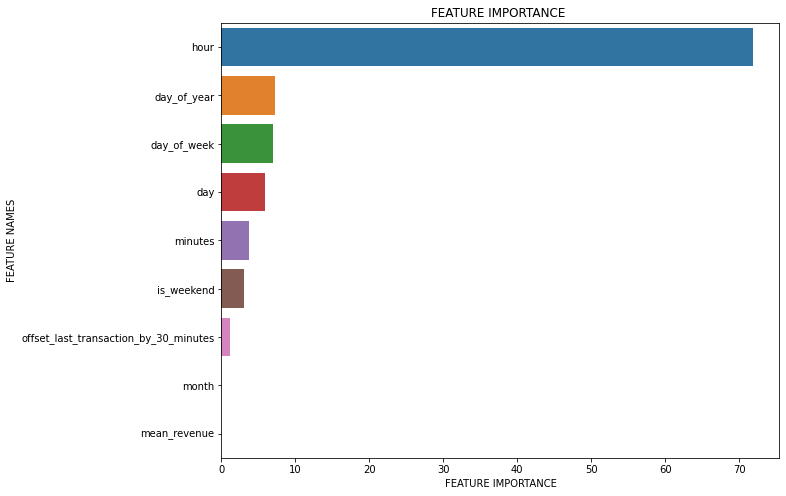

In [650]:
t = t.fillna(-1)
X = t.drop(columns=['timeThirty', 'point', 
                     'new_revenue', 'revenue'
                      # 'mean_revenue', 'timeHour', 
                     ])
y = t['new_revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = CatBoostRegressor(random_state=42, eval_metric="RMSE", iterations=100)
clf.fit(X_train, y_train,
        # cat_features=["point"],
        eval_set=(X_test, y_test),
        plot=True
)
y_predicted = clf.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
mae = mean_absolute_error(y_test, y_predicted)
rmse, mae
plot_feature_importance(clf.get_feature_importance(),
                        X.columns)

In [651]:
rmse, mae

(1395.0769369919929, 1078.0172858815306)

In [640]:
revenue_05[revenue_05["point"] == "Точка продаж 3"][:20]

,timeThirty,revenue,point,day_of_week,day_of_year,day,month,hour,minutes,mean_revenue,is_weekend
2,2022-05-01 00:00:00+00:00,1574.5,Точка продаж 3,6,121,1,5,0,0,4230.531963,1
21,2022-05-01 00:30:00+00:00,931.0,Точка продаж 3,6,121,1,5,0,30,4230.531963,1
51,2022-05-01 01:00:00+00:00,684.0,Точка продаж 3,6,121,1,5,1,0,4230.531963,1
62,2022-05-01 01:30:00+00:00,1996.5,Точка продаж 3,6,121,1,5,1,30,4230.531963,1
77,2022-05-01 02:00:00+00:00,124.5,Точка продаж 3,6,121,1,5,2,0,4230.531963,1
102,2022-05-01 03:30:00+00:00,793.5,Точка продаж 3,6,121,1,5,3,30,4230.531963,1
123,2022-05-01 04:00:00+00:00,1319.0,Точка продаж 3,6,121,1,5,4,0,4230.531963,1
140,2022-05-01 04:30:00+00:00,2466.0,Точка продаж 3,6,121,1,5,4,30,4230.531963,1
153,2022-05-01 05:00:00+00:00,4731.0,Точка продаж 3,6,121,1,5,5,0,4230.531963,1
167,2022-05-01 05:30:00+00:00,3494.5,Точка продаж 3,6,121,1,5,5,30,4230.531963,1


In [603]:
dep[(dep["boarding_end_msk_round"] >= '2022-05-01 00:00:00')&(dep["departure_terminal"]=='B')].groupby('boarding_end_msk_round').agg({'flight_number': np.count_nonzero})[:20]

,flight_number
boarding_end_msk_round,
2022-05-01 00:00:00+00:00,3
2022-05-01 00:30:00+00:00,2
2022-05-01 01:00:00+00:00,3
2022-05-01 01:30:00+00:00,3
2022-05-01 02:00:00+00:00,1
2022-05-01 05:30:00+00:00,5
2022-05-01 06:00:00+00:00,7
2022-05-01 06:30:00+00:00,2
2022-05-01 07:00:00+00:00,3


In [604]:
dep[dep["boarding_end_msk_round"] >= '2022-05-01 00:00:00'].groupby('boarding_end_msk_round').agg({'flight_number': np.count_nonzero})[:20]



,flight_number
boarding_end_msk_round,
2022-05-01 00:00:00+00:00,3
2022-05-01 00:30:00+00:00,3
2022-05-01 01:00:00+00:00,4
2022-05-01 01:30:00+00:00,4
2022-05-01 02:00:00+00:00,2
2022-05-01 05:30:00+00:00,5
2022-05-01 06:00:00+00:00,7
2022-05-01 06:30:00+00:00,2
2022-05-01 07:00:00+00:00,4


In [606]:
dep[["boarding_end_msk_round", "boarding_end"]]

,boarding_end_msk_round,boarding_end
0,2022-04-29 01:30:00+00:00,2022-04-28 22:53:00+00:00
1,2022-04-29 00:30:00+00:00,2022-04-28 21:41:00+00:00
2,2022-04-28 23:30:00+00:00,2022-04-28 20:54:00+00:00
3,2022-04-29 00:00:00+00:00,2022-04-28 21:02:00+00:00
4,2022-04-29 00:00:00+00:00,2022-04-28 21:00:00+00:00
...,...,...
13378,2022-07-01 23:30:00+00:00,2022-07-01 20:32:00+00:00
13379,2022-07-01 23:00:00+00:00,2022-07-01 20:28:00+00:00
13380,2022-07-01 23:00:00+00:00,2022-07-01 20:28:00+00:00
13381,2022-07-01 23:30:00+00:00,2022-07-01 20:39:00+00:00


In [607]:
df[df["point"] == "Точка продаж 3"]

,timeThirty,revenue,point,day_of_week,day_of_year,day,month,hour,minutes,mean_revenue,is_weekend,timeHour,datetime,temp,wind_speed,visibility,sky_coverage,count_clients,count_B_clients,count_C_clients,count_SU_clients,count_FV_clients,count_domestic_clients,count_international_clients,calc_sum_seats,calc_sum_seats_c,calc_sum_seats_w,calc_sum_seats_y,calc_avg_distance,calc_avg_temp,calc_avg_lat,calc_avg_lon,calc_avg_boarding_time,calc_avg_delay_time,calc_avg_departure_gate,calc_min_departure_gate,calc_max_departure_gate,calc_elev1C_departure_gate,calc_elev2C_departure_gate,calc_elev3C_departure_gate,calc_elev1B_departure_gate,calc_elev2B_departure_gate,calc_elev3B_departure_gate,int_point
2,2022-05-01 00:00:00+00:00,1574.5,Точка продаж 3,6,121,1,5,0,0,4230.531963,1,2022-05-01 00:00:00+00:00,2022-05-01 00:00:00+00:00,-0.0,7.2,10000.0,-1.0,11,8,3,9,2,8,3,1638,220,0,1418,2342.459046,7.181818,52.071211,71.187961,1450.909091,872.727273,114.981113,101.0,138.000000,0,0,2,4,0,5,3
21,2022-05-01 00:30:00+00:00,931.0,Точка продаж 3,6,121,1,5,0,30,4230.531963,1,2022-05-01 00:00:00+00:00,2022-05-01 00:00:00+00:00,-0.0,7.2,10000.0,-1.0,10,7,3,7,3,7,3,1415,184,0,1231,2252.442493,3.900000,54.304497,70.893854,1380.000000,876.000000,112.818837,101.0,138.000000,0,0,1,3,0,6,3
51,2022-05-01 01:00:00+00:00,684.0,Точка продаж 3,6,121,1,5,1,0,4230.531963,1,2022-05-01 01:00:00+00:00,2022-05-01 01:00:00+00:00,-0.0,7.2,10000.0,-1.0,6,4,2,4,2,4,2,908,112,0,796,2272.607103,4.333333,53.355220,70.680875,1410.000000,880.000000,115.632041,101.0,138.000000,0,0,1,1,0,4,3
62,2022-05-01 01:30:00+00:00,1996.5,Точка продаж 3,6,121,1,5,1,30,4230.531963,1,2022-05-01 01:00:00+00:00,2022-05-01 01:00:00+00:00,-0.0,7.2,10000.0,-1.0,2,1,1,1,1,1,1,227,32,0,195,2023.975683,-2.500000,59.638192,70.035270,1200.000000,600.000000,111.698062,111.0,112.396124,0,0,0,0,0,2,3
77,2022-05-01 02:00:00+00:00,124.5,Точка продаж 3,6,121,1,5,2,0,4230.531963,1,2022-05-01 02:00:00+00:00,2022-05-01 02:00:00+00:00,-1.0,0.0,10000.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27281,2022-05-31 22:00:00+00:00,5994.5,Точка продаж 3,1,151,31,5,22,0,4230.531963,0,2022-05-31 22:00:00+00:00,2022-05-31 22:00:00+00:00,15.0,0.0,10000.0,0.4,20,16,4,13,7,16,4,3211,380,96,2735,2304.891967,10.100000,53.322297,66.554947,1395.000000,870.000000,111.488643,101.0,126.000000,0,0,1,4,0,15,3
27296,2022-05-31 22:30:00+00:00,4058.0,Точка продаж 3,1,151,31,5,22,30,4230.531963,0,2022-05-31 22:00:00+00:00,2022-05-31 22:00:00+00:00,15.0,0.0,10000.0,0.4,14,10,4,7,7,10,4,1661,224,0,1437,1911.107645,11.071429,52.803097,61.416362,1302.857143,887.142857,112.626633,102.0,121.000000,0,0,0,1,0,13,3
27317,2022-05-31 23:00:00+00:00,3307.0,Точка продаж 3,1,151,31,5,23,0,4230.531963,0,2022-05-31 23:00:00+00:00,2022-05-31 23:00:00+00:00,15.0,7.2,5000.0,0.6,14,10,4,8,6,10,4,1732,232,0,1500,2293.232967,11.000000,52.731235,68.906345,1290.000000,805.714286,114.169767,102.0,123.000000,0,0,0,1,2,11,3
27337,2022-05-31 23:30:00+00:00,1002.0,Точка продаж 3,1,151,31,5,23,30,4230.531963,0,2022-05-31 23:00:00+00:00,2022-05-31 23:00:00+00:00,15.0,7.2,5000.0,0.6,11,9,2,8,3,9,2,1453,196,0,1257,2441.278173,12.363636,53.496822,72.260226,1287.272727,501.818182,112.926216,102.0,123.000000,0,0,0,2,2,7,3


In [608]:
dep

,carrier,flight_number,aircraft_type,aircraft_registration,registration_start,registration_end,boarding_start,boarding_end,departure_airportCode,departure_actualBlockOff,departure_scheduledDeparture,departure_actualTakeOff,departure_gate,departure_terminal,arrival_scheduled_airportCode,arrival_latest_airportCode,arrival_scheduledArrival,arrival_actualTouchDown,arrival_deboardingStart,arrival_deboardingStop,deboarding_start,deboarding_end,status,operatingBy,name_x,seats,seats_C,seats_W,seats_Y,boarding_end_msk,boarding_end_msk_round,boarding_end_round_1_hour,shoping_start_msk,shoping_stop_msk,name_y,iata,icao,lat,lon,country,alt,datetime,temp,wind_speed,visibility,sky_coverage,distance,delay_time,boarding_time
0,SU,1510,320,73762,2022-04-27T23:00:00Z,2022-04-28T22:15:00Z,2022-04-28T22:29:00Z,2022-04-28 22:53:00+00:00,SVO,2022-04-28T23:25:00Z,2022-04-28T18:45:00Z,2022-04-28T23:38:00Z,104.000000,B,SGC,SGC,2022-04-28T22:00:00Z,2022-04-29T02:40:00Z,NaN,NaN,2022-04-29T02:45:00Z,2022-04-29T03:15:00Z,Arrived,SU,Airbus A320,140,20,0,120,2022-04-29 01:53:00+00:00,2022-04-29 01:30:00+00:00,2022-04-28 22:00:00+00:00,2022-04-28 23:53:00+00:00,2022-04-29 01:23:00+00:00,Surgut International Airport,SGC,USRR,61.343689,73.401840,Russia,200,NaT,-10.0,-10.0,-10.0,-10.0,2141.922704,17580.0,1440.0
1,SU,1646,320,VPBKP,2022-04-27T22:00:00Z,2022-04-28T21:15:00Z,2022-04-28T21:21:00Z,2022-04-28 21:41:00+00:00,SVO,2022-04-28T21:55:00Z,2022-04-28T19:45:00Z,2022-04-28T22:06:00Z,121.000000,B,NJC,NJC,2022-04-28T23:15:00Z,2022-04-29T00:57:00Z,NaN,NaN,2022-04-29T01:01:00Z,2022-04-29T01:31:00Z,Arrived,SU,Airbus A320,140,20,0,120,2022-04-29 00:41:00+00:00,2022-04-29 00:30:00+00:00,2022-04-28 21:00:00+00:00,2022-04-28 22:41:00+00:00,2022-04-29 00:11:00+00:00,Nizhnevartovsk Airport,NJC,USNN,60.949268,76.483612,Russia,177,NaT,-10.0,-10.0,-10.0,-10.0,2309.238896,8460.0,1200.0
2,SU,1966,SU9,89026,2022-04-27T21:10:00Z,2022-04-28T20:25:00Z,2022-04-28T20:33:00Z,2022-04-28 20:54:00+00:00,SVO,2022-04-28T21:07:00Z,2022-04-28T21:10:00Z,2022-04-28T21:17:00Z,135.000000,C,EVN,EVN,2022-04-29T01:15:00Z,2022-04-29T00:43:00Z,NaN,NaN,2022-04-29T00:47:00Z,2022-04-29T01:17:00Z,Arrived,SU,Sukhoi Superjet 100-95,87,12,0,75,2022-04-28 23:54:00+00:00,2022-04-28 23:30:00+00:00,2022-04-28 20:00:00+00:00,2022-04-28 21:54:00+00:00,2022-04-28 23:24:00+00:00,Yerevan Zvartnots International Airport,EVN,UDYZ,40.147270,44.395882,Armenia,2838,NaT,-10.0,-10.0,-10.0,-10.0,1832.689680,420.0,1260.0
3,SU,1524,321,73725,2022-04-27T21:10:00Z,2022-04-28T20:25:00Z,2022-04-28T20:31:00Z,2022-04-28 21:02:00+00:00,SVO,2022-04-28T21:10:00Z,2022-04-28T21:10:00Z,2022-04-28T21:22:00Z,111.000000,B,RGK,RGK,2022-04-29T01:35:00Z,2022-04-29T01:10:00Z,2022-04-28T19:49:00Z,NaN,2022-04-29T01:15:00Z,2022-04-29T01:45:00Z,Arrived,SU,Airbus A321,170,28,0,142,2022-04-29 00:02:00+00:00,2022-04-29 00:00:00+00:00,2022-04-28 21:00:00+00:00,2022-04-28 22:02:00+00:00,2022-04-28 23:32:00+00:00,Gorno-Altaysk Airport,RGK,UNBG,51.969166,85.836388,Russia,959,NaT,-10.0,-10.0,-10.0,-10.0,3141.949923,720.0,1860.0
4,SU,1478,320,73732,2022-04-27T21:15:00Z,2022-04-28T20:30:00Z,2022-04-28T20:37:00Z,2022-04-28 21:00:00+00:00,SVO,2022-04-28T21:08:00Z,2022-04-28T21:15:00Z,2022-04-28T21:19:00Z,110.000000,B,ABA,ABA,2022-04-29T01:50:00Z,2022-04-29T01:18:00Z,NaN,NaN,2022-04-29T01:22:00Z,2022-04-29T01:52:00Z,Arrived,SU,Airbus A320,140,20,0,120,2022-04-29 00:00:00+00:00,2022-04-29 00:00:00+00:00,2022-04-28 21:00:00+00:00,2022-04-28 22:00:00+00:00,2022-04-28 23:30:00+00:00,Abakan International Airport,ABA,UNAA,53.740002,91.385002,Russia,831,NaT,-10.0,-10.0,-10.0,-10.0,3386.162600,240.0,1380.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13378,SU,1408,320,73766,2022-06-30T20:45:00Z,2022-07-01T20:00:00Z,2022-07-01T20:07:00Z,2022-07-01 20:32:00+00:00,SVO,2022-07-01T20:39:00Z,2022-07-01T20:45:00Z,2022-07-